# Computing the instanton of the Egger system

Ref: *J. Egger, Journal of the Atmospheric Sciences 38, 2606 (1981)*

## Import statements

In [1]:
# Modify path environment variables to search for the local Pyritz and NLopt installations in the repository.

import os, sys

pyritz_dir = "/".join(os.getcwd().split("/")[:-1])
nlopt_lib_dir = "%s/nlopt/lib" % pyritz_dir
nlopt_py_dir = "%s/nlopt/nlopt_py" % pyritz_dir

if "LD_LIBRARY_PATH" in os.environ:
    paths = os.environ["LD_LIBRARY_PATH"].split(":")
    paths.append(nlopt_lib_dir)
    os.environ["LD_LIBRARY_PATH"] = ":".join(paths)
else:
    os.environ["LD_LIBRARY_PATH"] = ":%s" % nlopt_lib_dir
    
sys.path.insert(0, nlopt_py_dir)
sys.path.insert(0, pyritz_dir)

# Import statements

import pyritz

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import nlopt

## Define system

#### System:

$$
dX = a(X)dt + \sqrt{\epsilon} dW.
$$

where

$$
a(x_1, x_2, x_3) =
\begin{pmatrix}
k x_2(x_3-\beta/k^2)\,dt - \gamma x_1 \\
-k x_1(x_3-\beta/k^2) + x_3 H/k - \gamma x_2 \\
-x_2 Hk/2 -\gamma(x_3-U_0)
\end{pmatrix}
$$

and

$$
\nabla a = \begin{pmatrix}
    -\gamma & -k x_3 + \frac{\beta}{k} & 0 \\
    k \left(x_3 - \frac{\beta}{k^2} \right) & - \gamma & - \frac{H k}{2} \\
    x_2 k & \frac{H}{k} - x_1 k & -\gamma
\end{pmatrix}
$$

where $(\nabla a)_{ij} = \frac{\partial a_i}{\partial x_j}$.

#### Lagrangian:

$$
L(x, x') = |x'| |a(x)| - x' \cdot a(x)
$$

#### Derivatives of the Lagrangian:

$$
\begin{aligned}
\frac{\partial L}{\partial x_i} & = \sum_{j=1}^{\text{dim}} \left[ \nabla_i a_j( x ) \cdot \left( |\dot x| \hat{a}_j(x) - \dot x_j \right) \right] \\
\frac{\partial L}{\partial x'_i} & = |a(x)| \hat{x}'_i - a_i(x)
\end{aligned}
$$

In [2]:
# System parameters

m_k = 2; m_rk = 1.0/m_k
m_k_sqrd = m_k*m_k; m_k_rsqrd = 1.0/(m_k*m_k)
m_beta = 1.25
m_gamma = 2
m_H = 12
m_U0 = 10.5

# Fixed points

e_xa = np.array([3.069644389978611, 0.3916588106895046, 8.150047135862973])
e_xb = np.array([0.46463458238449845, 1.6510126673223484, 0.5939239960659098])
e_xs = np.array([2.7990543599971227, 1.3531618554007454, 2.3810288675955276])

# System Lagrangian

def system_a(xs):
    x1, x2, x3 = xs
    return np.array([m_k*x2*(x3 - m_beta*m_k_rsqrd) - m_gamma*x1,
                     -m_k*x1*(x3 - m_beta*m_k_rsqrd) + x3*m_H*m_rk - m_gamma*x2,
                     - x2*m_H*m_k*0.5 - m_gamma*(x3 - m_U0) ])

def lagrangian(ls, dxls, dvls, path, us, args):
    xs, vs = path
    
    sas = system_a(xs)
    v_norms = np.linalg.norm(vs, axis=0)
    sa_norms = np.linalg.norm(sas, axis=0)
    vs_dot_sas = np.einsum("ij,ij->j", vs, sas)
    
    ls[:] = v_norms * sa_norms - vs_dot_sas
    
    if not dxls is None:

        ## Compute dL/dx

        da = np.zeros( (xs.shape[0], xs.shape[0], dxls.shape[1]) )
        da[0,0, :] = da[1,1, :] = da[2,2, :] = -m_gamma
        da[0,1, :] = -m_k * xs[2,:] + m_beta*m_rk
        da[1,0, :] = m_k*( xs[2,:] - m_beta*m_k_rsqrd )
        da[1,2, :] = - m_H * m_k * 0.5
        da[2,0, :] = xs[1,:] * m_k
        da[2,1, :] = m_H*m_rk - xs[0,:]*m_k

        f = np.where(sa_norms!=0)
        sa_units = np.zeros(sas.shape)
        sa_units[:, f] = sas[:, f]/sa_norms[f]

        dxls[:] = np.einsum("jki,ki->ji", da, v_norms*sa_units - vs)

        ## Compute dL/dv

        f = np.where(v_norms!=0)
        avs = np.zeros(vs.shape)
        avs[:, f] = vs[:, f]*sa_norms[f]/v_norms[f]

        dvls[:] = avs - sas

## Computing the instanton

### Gradient-based optimisation

In [3]:
x1 = e_xa
x2 = e_xb

n = 8
nq = n*10

action = pyritz.interpolation.Action(lagrangian, n, nq, x1, x2)
alpha0 = pyritz.interpolation.utils.linear_path(x1, x2, n)

opt = nlopt.opt(nlopt.LD_SLSQP, np.size(alpha0))
opt.set_min_objective(action.compute)
opt.set_xtol_rel(1e-16)
alpha = opt.optimize(alpha0)

print("S[alpha0] = %s" % action.compute(alpha0))
print("S[alpha]  = %s" % action.compute(alpha))

S[alpha0] = 58.96645276162779
S[alpha]  = 10.046445150513229


#### Instanton plot

<IPython.core.display.Javascript object>


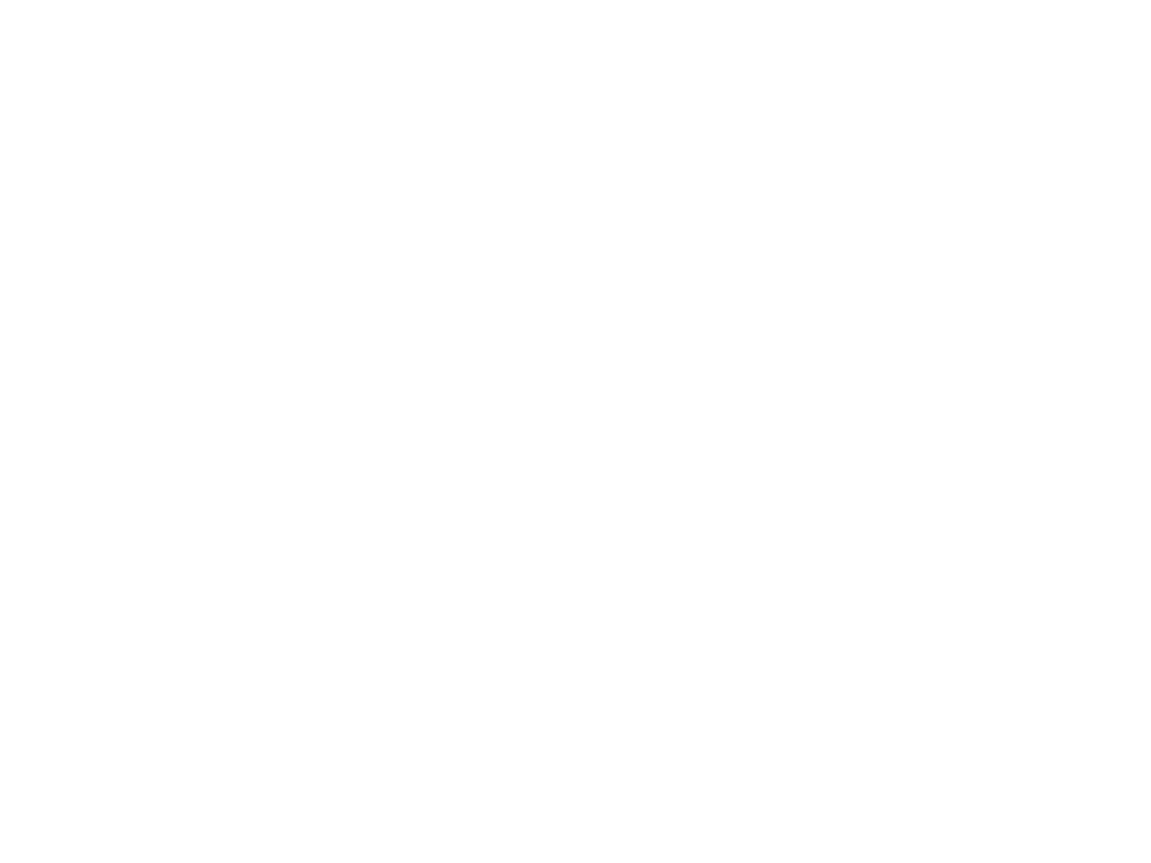

In [4]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

us = np.linspace(-1, 1, 1000)

paths = [
    (action.get_alpha_with_endpoints(alpha0), "Initial"),
    (action.get_alpha_with_endpoints(alpha), "Final")
]

mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure()
ax = fig.gca(projection='3d')

for _alpha, _label in paths:
    xs = pyritz.interpolation.utils.interpolate(_alpha, n, us)
    ax.plot(xs[0,:], xs[1,:], xs[2,:], label=_label)
    
ax.text(e_xa[0], e_xa[1], e_xa[2], "a")
ax.text(e_xb[0], e_xb[1], e_xb[2], "b")
ax.text(e_xs[0], e_xs[1], e_xs[2], "s")

ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel("U")

ax.legend()
plt.show()

### Gradient-free optimisation

In [5]:
x1 = e_xa
x2 = e_xb

n = 8
nq = n*10

action = pyritz.interpolation.Action(lagrangian, n, nq, x1, x2)
alpha0 = pyritz.interpolation.utils.linear_path(x1, x2, n)
alpha0 += np.random.random(len(alpha0))*0.1 # Add random noise to the initial path

opt = nlopt.opt(nlopt.LN_NEWUOA, np.size(alpha0))
opt.set_min_objective(action.compute)
opt.set_xtol_rel(1e-16)
alpha = opt.optimize(alpha0)

print("S[alpha0] = %s" % action.compute(alpha0))
print("S[alpha]  = %s" % action.compute(alpha))

S[alpha0] = 55.25000962627641
S[alpha]  = 10.046445150513543


#### Instanton plot

<IPython.core.display.Javascript object>


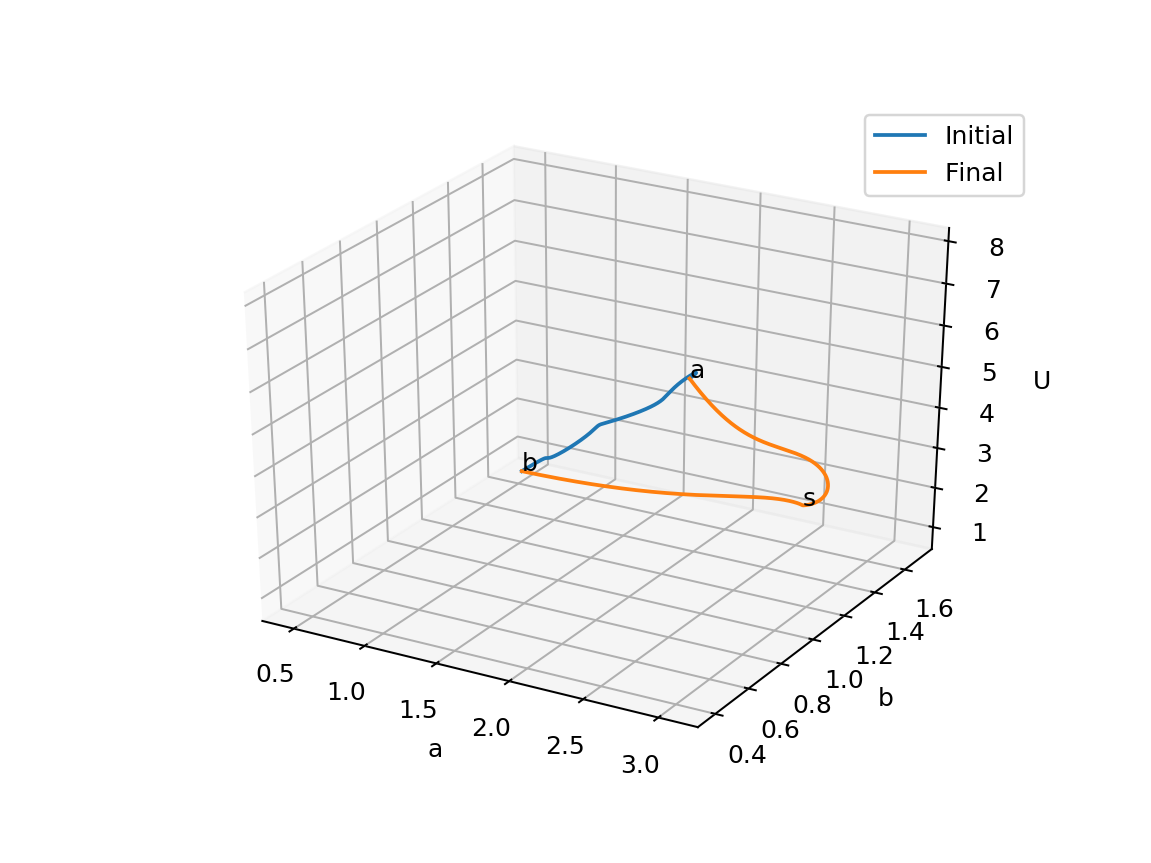

In [6]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

us = np.linspace(-1, 1, 1000)

paths = [
    (action.get_alpha_with_endpoints(alpha0), "Initial"),
    (action.get_alpha_with_endpoints(alpha), "Final")
]

mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure()
ax = fig.gca(projection='3d')

for _alpha, _label in paths:
    xs = pyritz.interpolation.utils.interpolate(_alpha, n, us)
    ax.plot(xs[0,:], xs[1,:], xs[2,:], label=_label)
    
ax.text(e_xa[0], e_xa[1], e_xa[2], "a")
ax.text(e_xb[0], e_xb[1], e_xb[2], "b")
ax.text(e_xs[0], e_xs[1], e_xs[2], "s")

ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel("U")

ax.legend()
plt.show()